# Required Libraries

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from mp_api.client import MPRester

from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.structure import DensityFeatures, GlobalSymmetryFeatures
from pymatgen.core import Structure

from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model, save_model, load_model
import xgboost as xgb
import joblib

# Data Scrapping

In [19]:
# 🔑 3. Fetch Data from Materials Project
API_KEY = '2yqf6FmGq648PC6a4JaNk1jXd5G5LyKo'  # Replace with your Materials Project API key
mpr = MPRester(API_KEY)

# Fetching materials data with specific properties
with MPRester(API_KEY) as mpr:
        entries = mpr.materials.summary.search(
        fields=['formula_pretty', 'formation_energy_per_atom', 'structure'],
        num_chunks=9,
        #num_chunks=None
        chunk_size=500
        )

print(f"Retrieved {len(entries)} Materials with their desired properties.")

Retrieving SummaryDoc documents:   0%|          | 0/4500 [00:00<?, ?it/s]

Retrieved 4500 Materials with their desired properties.


In [3]:
print(entries[0].model_dump())

{'builder_meta': None, 'nsites': None, 'elements': None, 'nelements': None, 'composition': None, 'composition_reduced': None, 'formula_pretty': 'O2', 'formula_anonymous': None, 'chemsys': None, 'volume': None, 'density': None, 'density_atomic': None, 'symmetry': None, 'property_name': None, 'material_id': None, 'deprecated': None, 'deprecation_reasons': None, 'last_updated': None, 'origins': None, 'warnings': None, 'structure': Structure Summary
Lattice
    abc : 5.160296 5.2402447696794665 5.89021299170463
 angles : 90.23517285321574 90.49680784381113 90.25713099844408
 volume : 159.2695518855733
      A : 5.160296 0.0 0.0
      B : -0.023517 5.240192 0.0
      C : -0.051073 -0.024406 5.889941
    pbc : True True True
PeriodicSite: O (4.4080, 2.5940, 5.8225) [0.8663, 0.4996, 0.9886]
PeriodicSite: O (0.4295, 2.2106, 5.7774) [0.0949, 0.4264, 0.9809]
PeriodicSite: O (1.8839, 5.1653, 3.0112) [0.3746, 0.9881, 0.5112]
PeriodicSite: O (3.0761, 0.3396, 3.0839) [0.6016, 0.0672, 0.5236]
Periodi

In [21]:
# --- Step 3: Convert to DataFrame for analysis ---
# Each entry is a SummaryDoc Object; convert to rows
data = []
for i in entries:
    data.append({
        
        "formula": i.formula_pretty,
        "structure": i.structure,
        "formation_energy_per_atom": i.formation_energy_per_atom,
    })

df = pd.DataFrame(data)
df.to_csv("Formation Energy Data.csv", index=False)

In [22]:
df.head()

,formula,structure,formation_energy_per_atom
0,Nb,"[[-0.99328832 -0.42135479 3.13782546] Nb, [1....",0.189748
1,Si,"[[3.02219719 3.56784026 2.0565257 ] Si, [0.964...",0.372510
2,Rb,"[[2.2041556 6.93248144 2.06237757] Rb, [5.219...",0.053649
3,O2,"[[1.99968417 3.6935332 3.93966005] O, [2.7593...",0.419854
4,O2,"[[4.40802865 2.5939677 5.82250118] O, [0.4294...",0.387014


# Featurization  
Composition featurization: Used Matminers element property  which used 'Magpie presets'.  
Structure Features: Used Matminers Desity and Global symmetry featurizers.

In [23]:
# 🧩 4. Feature Engineering
#df = pd.read_csv("Formation Energy Data.csv")
df['composition'] = df['formula'].apply(Composition)

# Composition Features
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(df, col_id='composition', ignore_errors=True)

# Structure Features
structure_features = []
for s in df['structure']:
    features = {}
    try:
        dens_feat = DensityFeatures().featurize(s)
        features.update(dict(zip(DensityFeatures().feature_labels(), dens_feat)))

        gsf_feat = GlobalSymmetryFeatures().featurize(s)
        features.update(dict(zip(GlobalSymmetryFeatures().feature_labels(), gsf_feat)))
    except Exception as e:
        features = {f: np.nan for f in features.keys()}
    structure_features.append(features)

structure_df = pd.DataFrame(structure_features)

ElementProperty:   0%|          | 0/4500 [00:00<?, ?it/s]

# Data curing

In [24]:
# Merge composition and structure features
X = pd.concat([df, structure_df], axis=1)

# Drop columns that aren't features
X = X.drop(columns=['composition', 'structure', 'formation_energy_per_atom'])

# Drop rows with any missing values
X = X.dropna()

# Now align y with the rows that remain in X,  Since we dropped rows in X, the index might be different.
y = df.loc[X.index, 'formation_energy_per_atom']

In [25]:
#print(X[:5])
print(y[:5])

0    0.189748
1    0.372510
2    0.053649
3    0.419854
4    0.387014
Name: formation_energy_per_atom, dtype: float64


In [26]:
model_data = pd.concat([X, y], axis=1)
#model_data.to_csv("model_data_curated_featurized.csv", index=False)
model_data.rename(columns={'formation_energy_per_atom': 'target'}, inplace=True)
print(model_data.dtypes)

formula                       object
MagpieData minimum Number    float64
MagpieData maximum Number    float64
MagpieData range Number      float64
MagpieData mean Number       float64
                              ...   
crystal_system                object
crystal_system_int           float64
is_centrosymmetric            object
n_symmetry_ops               float64
target                       float64
Length: 142, dtype: object


In [27]:
non_numeric_cols = model_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['formula', 'crystal_system', 'is_centrosymmetric'], dtype='object')


In [32]:
# Make a copy of your model_data
model_data_clean = model_data.copy()

# Drop 'formula' (we already extracted features from it)
model_data_clean = model_data_clean.drop(columns=['formula'])

# Handle 'crystal_system' (one-hot encoding)
model_data_clean = pd.get_dummies(model_data_clean, columns=['crystal_system'])

# Handle 'is_centrosymmetric' via one-hot-encoding (map True/False to 1/0). In some cases it might be a string, so let's handle both cases robustly
model_data_clean['is_centrosymmetric'] = model_data_clean['is_centrosymmetric'].map({
    True: 1, False: 0, 
    'True': 1, 'False': 0
})
model_data_clean.to_csv("model_data_all_featurized_curated.csv", index=False)
# Save the last 278 rows as unseen data
unseen_data = model_data_clean.tail(278)
model_data_clean = model_data_clean.iloc[:-278]  # saves the rest for model training and optimization

# Reset index for both datasets
model_data_clean.reset_index(drop=True, inplace=True)
unseen_data.reset_index(drop=True, inplace=True)

# Double-check dtypes
print(model_data_clean.dtypes)
print( "cleaned dataset size for model training and validation:", model_data_clean.shape)
print( "cleaned Unseen dataset size:", unseen_data.shape)

MagpieData minimum Number      float64
MagpieData maximum Number      float64
MagpieData range Number        float64
MagpieData mean Number         float64
MagpieData avg_dev Number      float64
                                ...   
crystal_system_monoclinic         bool
crystal_system_orthorhombic       bool
crystal_system_tetragonal         bool
crystal_system_triclinic          bool
crystal_system_trigonal           bool
Length: 147, dtype: object
cleaned dataset size for model training and validation: (4200, 147)
cleaned Unseen dataset size: (278, 147)


In [29]:
non_numeric_cols_clean = model_data_clean.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols_clean)

Non-numeric columns: Index([], dtype='object')


# Model Selection :
Pycaret is used.  
https://pycaret.gitbook.io/docs  
Models were choosen based on sorting metrics: 1. mean absolute error (mae), i.e., focusing on prediction accuracy  2. R2 score, i.e., focusing on capturing the variance in the training dataset.

1. Model Selection: Metric 'mae'

In [38]:
from pycaret.regression import *
# Setup
regression_setup_mae = setup(
    data=model_data_clean,
    target='target',
    session_id=123,
    fold=5,
    train_size=0.8,
    n_jobs=-1,
    verbose=False,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    #remove_outliers=True,
    #outliers_threshold=0.05
)

# Compare, tune, finalize models
best_model_mae = compare_models(sort='MAE', n_select=3)
# Save MAE leaderboard
leaderboard_mae = pull()[['Model', 'MAE', 'R2']].head(3)

tuned_model_mae = tune_model(best_model_mae[0], optimize='MAE', search_library='scikit-optimize')
final_model_mae= finalize_model(tuned_model_mae)

# Save : final_model used the metric R2.
save_model(final_model_mae, 'formation_energy_final_model_mae')

# Load the saved model
model_mae = load_model('formation_energy_final_model_mae')

# Retrieve holdout set
X_test_mae = get_config('X_test')
y_test_mae = get_config('y_test')
X_train_mae = get_config('X_train')
y_train_mae = get_config('y_train')

# Get predictions using the final model
predictions_df_mae = predict_model(model_mae, data=X_test_mae)

# The predictions are in the 'Label' column
y_pred_mae = predictions_df_mae['prediction_label']
y_pred_mae.head()
print("Prediction_mae list size:",  y_pred_mae.shape)
print("target_test_mae list size:",  y_test_mae.shape)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.1878,0.1740,0.4157,0.8561,0.1712,340023054.4339,4.7160
et,Extra Trees Regressor,0.1879,0.2257,0.4728,0.8160,0.1844,3037721568.0704,1.2260
lightgbm,Light Gradient Boosting Machine,0.1949,0.1590,0.3983,0.8699,0.1683,5298939284.5912,0.3600
xgboost,Extreme Gradient Boosting,0.1964,0.2045,0.4500,0.8308,0.1814,2790698418.2206,0.4180
rf,Random Forest Regressor,0.1982,0.1919,0.4369,0.8429,0.1808,3244226853.4801,1.7640
gbr,Gradient Boosting Regressor,0.2475,0.2219,0.4705,0.8182,0.2026,8238406884.3511,0.7200
dt,Decision Tree Regressor,0.2573,0.3598,0.5953,0.7067,0.2312,1900855440.5502,0.2240
knn,K Neighbors Regressor,0.3564,0.3778,0.6137,0.6933,0.2680,6046160927.8449,0.1660
br,Bayesian Ridge,0.3820,0.3615,0.6004,0.7051,0.2570,28102351281.8766,0.1720
ridge,Ridge Regression,0.3831,0.3584,0.5979,0.7074,0.2573,21186981092.2851,0.1660


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2901,0.3337,0.5776,0.7532,0.2293,2.6924
1,0.3051,0.2502,0.5002,0.8018,0.2327,185.0053
2,0.3049,0.3033,0.5507,0.7423,0.2392,15.9670
3,0.2832,0.2106,0.4589,0.8361,0.2022,6.9890
4,0.3073,0.2336,0.4833,0.7820,0.2322,57547223170.6349
Mean,0.2981,0.2663,0.5142,0.7831,0.2271,11509444676.2577
Std,0.0097,0.0455,0.0437,0.0338,0.0129,23018889247.1886


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Prediction_mae list size: (840,)
target_test_mae list size: (840,)


2. Model selection: Metric R2

In [37]:
from pycaret.regression import get_config
# Setup
regression_setup = setup(
    data=model_data_clean,
    target='target',
    session_id=123,
    fold=5,
    train_size=0.8,
    n_jobs=-1,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    verbose=False,
    #remove_outliers=True,
    #outliers_threshold=0.05
    )

# Compare, Tune, Finalize 
best_model = compare_models(sort='R2', n_select=3)
# Save R2 leaderboard
leaderboard_r2 = pull()[['Model', 'R2', 'MAE']].head(3)

tuned_model = tune_model(best_model[0], optimize='R2', search_library='scikit-optimize')
final_model = finalize_model(tuned_model)

# Save : final_model used the metric R2.
save_model(final_model, 'formation_energy_final_model')

# Load the saved model
model = load_model('formation_energy_final_model')

# Retrieve holdout set
X_test = get_config('X_test')
y_test = get_config('y_test')
X_train = get_config('X_train')
y_train = get_config('y_train')


# Get predictions using the final model
predictions_df = predict_model(model, data=X_test)

# The predictions are in the 'Label' column
y_pred = predictions_df['prediction_label']
y_pred.head()
print("Prediction list size:",  y_pred.shape)
print("Prediction list size:",  y_test.shape)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.1949,0.1590,0.3983,0.8699,0.1683,5298939284.5912,0.3620
catboost,CatBoost Regressor,0.1878,0.1740,0.4157,0.8561,0.1712,340023054.4339,4.6620
rf,Random Forest Regressor,0.1982,0.1919,0.4369,0.8429,0.1808,3244226853.4801,1.8980
xgboost,Extreme Gradient Boosting,0.1964,0.2045,0.4500,0.8308,0.1814,2790698418.2206,0.4220
gbr,Gradient Boosting Regressor,0.2475,0.2219,0.4705,0.8182,0.2026,8238406884.3511,0.7100
et,Extra Trees Regressor,0.1879,0.2257,0.4728,0.8160,0.1844,3037721568.0704,1.2000
ridge,Ridge Regression,0.3831,0.3584,0.5979,0.7074,0.2573,21186981092.2851,0.1660
lr,Linear Regression,0.3844,0.3588,0.5983,0.7071,0.2576,20039327767.5294,3.2060
dt,Decision Tree Regressor,0.2573,0.3598,0.5953,0.7067,0.2312,1900855440.5502,0.2020
br,Bayesian Ridge,0.3820,0.3615,0.6004,0.7051,0.2570,28102351281.8766,0.1740


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2610,0.3225,0.5679,0.7615,0.2212,2.2291
1,0.2760,0.2259,0.4753,0.8211,0.2218,118.5528
2,0.2734,0.2700,0.5196,0.7705,0.2327,30.4158
3,0.2791,0.2488,0.4988,0.8064,0.2169,6.6024
4,0.2697,0.2240,0.4733,0.7909,0.2182,36758771840.5801
Mean,0.2718,0.2583,0.5070,0.7901,0.2222,7351754399.6760
Std,0.0062,0.0363,0.0349,0.0220,0.0056,14703508720.4520


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Prediction list size: (840,)
Prediction list size: (840,)


*1. Evaluation Metric: Mean Absolute Error*

In [33]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

corrected_mape_mae = safe_mape(y_test_mae, y_pred_mae)
# Calculate other metrics
mae_mae = mean_absolute_error(y_test_mae, y_pred_mae)
rmse_mae = root_mean_squared_error(y_test_mae, y_pred_mae)
r2_mae = r2_score(y_test_mae, y_pred_mae)

print(f"Corrected MAPE_MAE: {corrected_mape_mae:.2f}%")
print(f"MAE_MAE: {mae_mae:.4f}")
print(f"RMSE_MAE: {rmse_mae:.4f}")
print(f"R2 Score_MAE: {r2_mae:.4f}")

Corrected MAPE_MAE: 359.75%
MAE_MAE: 0.0896
RMSE_MAE: 0.1655
R2 Score_MAE: 0.9753


2. evaluation: Metric- R2

In [34]:
corrected_mape = safe_mape(y_test, y_pred)
# Calculate other metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Corrected MAPE: {corrected_mape:.2f}%")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


Corrected MAPE: 381.83%
MAE: 0.1100
RMSE: 0.2274
R2 Score: 0.9534


# Model Analysis
https://pycaret.gitbook.io/docs/get-started/quickstart#regression

1. Sort: MAE

In [ ]:
from pycaret.regression import evaluate_model
from pycaret.regression import pull
# Setup
regression_setup_mae = setup(
    data=model_data_clean,
    target='target',
    session_id=123,
    fold=5,
    train_size=0.8,
    n_jobs=-1,
    verbose=False,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    #remove_outliers=True,
    #outliers_threshold=0.05
)
evaluate_model(model_mae)
print(best_model_mae)

# Use pull() after evaluate_model or plot_model to grab the results
summary_df_mae = pull()
print(summary_df_mae)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

[<catboost.core.CatBoostRegressor object at 0x000001E24BA98670>, ExtraTreesRegressor(n_jobs=-1, random_state=123), LGBMRegressor(n_jobs=-1, random_state=123)]
                    Description             Value
0                    Session id               123
1                        Target            target
2                   Target type        Regression
3           Original data shape       (4200, 147)
4        Transformed data shape        (4200, 94)
5   Transformed train set shape        (3360, 94)
6    Transformed test set shape         (840, 94)
7              Numeric features               139
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12     Remove multicollinearity              True
13  Multicollinearity threshold               0.9
14               Fold Generator             KFold
15                  Fold Number          

<Figure size 800x550 with 0 Axes>

2. Sort: R2

In [ ]:
# Setup
regression_setup = setup(
    data=model_data_clean,
    target='target',
    session_id=123,
    fold=5,
    train_size=0.8,
    n_jobs=-1,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.9,
    verbose=False,
    #remove_outliers=True,
    #outliers_threshold=0.05
    )

evaluate_model(model)
print(best_model)

# Use pull() after evaluate_model or plot_model to grab the results
summary_df = pull()
print(summary_df)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

[LGBMRegressor(n_jobs=-1, random_state=123), <catboost.core.CatBoostRegressor object at 0x000001E249050CD0>, RandomForestRegressor(n_jobs=-1, random_state=123)]
                    Description             Value
0                    Session id               123
1                        Target            target
2                   Target type        Regression
3           Original data shape       (4200, 147)
4        Transformed data shape        (4200, 94)
5   Transformed train set shape        (3360, 94)
6    Transformed test set shape         (840, 94)
7              Numeric features               139
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12     Remove multicollinearity              True
13  Multicollinearity threshold               0.9
14               Fold Generator             KFold
15                  Fold Number        

In [41]:
print("Columns in leaderboard_r2:")
print(leaderboard_r2.columns)

print("\nColumns in leaderboard_mae:")
print(leaderboard_mae.columns)

Columns in leaderboard_r2:
Index(['Model', 'R2', 'MAE'], dtype='object')

Columns in leaderboard_mae:
Index(['Model', 'MAE', 'R2'], dtype='object')


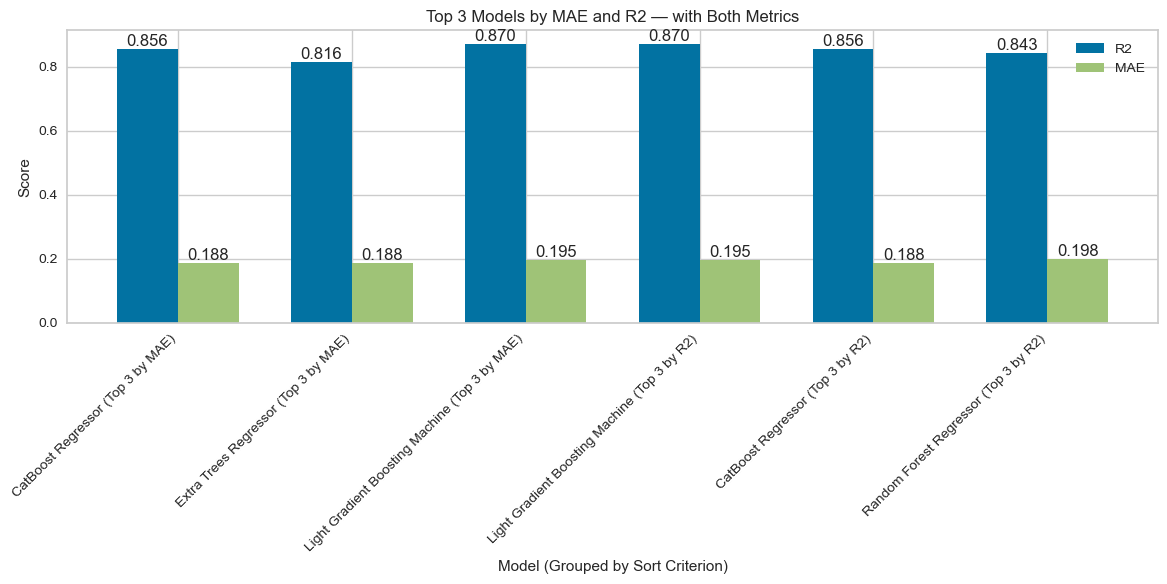

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Tag each model group by its selection metric
leaderboard_mae_grouped = leaderboard_mae[['Model', 'R2', 'MAE']].head(3).copy()
leaderboard_mae_grouped['Group'] = 'Top 3 by MAE'

leaderboard_r2_grouped = leaderboard_r2[['Model', 'R2', 'MAE']].head(3).copy()
leaderboard_r2_grouped['Group'] = 'Top 3 by R2'

# Combine and reset index
combined_df = pd.concat([leaderboard_mae_grouped, leaderboard_r2_grouped], ignore_index=True)

# To avoid duplicate model labels (if overlap), add source label
combined_df['Model_Label'] = combined_df['Model'] + " (" + combined_df['Group'] + ")"

# Plot settings
bar_width = 0.35
x_indexes = range(len(combined_df))

plt.figure(figsize=(12, 6))

# Plot bars
r2_bars = plt.bar([i - bar_width/2 for i in x_indexes], combined_df['R2'], width=bar_width, label='R2')
mae_bars = plt.bar([i + bar_width/2 for i in x_indexes], combined_df['MAE'], width=bar_width, label='MAE')

# Labels and layout
plt.xlabel("Model (Grouped by Sort Criterion)")
plt.ylabel("Score")
plt.title("Top 3 Models by MAE and R2 — with Both Metrics")
plt.xticks(ticks=x_indexes, labels=combined_df['Model_Label'], rotation=45, ha='right')
plt.legend()

# Annotate bars
for bars in [r2_bars, mae_bars]:
    for bar in bars:
        height = bar.get_height()
        if pd.notnull(height):
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()